# Итоговый проект по предмету: Методы машинного обучения для анализа временных рядов и панельных данных
## Выполнила: Шубина София Антоновна НПИбд-02-23

Задача: необходимо построить и обучить модель для прогноза высоты снежного 
покрова в зимний сезон. Добиться максимальных результатов на тестовых данных. 
По историческим данным построить прогноз на месяц вперед с 21 ноября до 21 
декабря 2025 г.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

Загружаем CSV-файл с погодными данными за 2017-2025 годы, преобразует столбец с датой в правильный формат datetime и устанавливает его как индекс таблицы для удобства работы с временными рядами. Затем код выводит первые 5 строк данных для беглого ознакомления, показывает техническую информацию о таблице — типы данных столбцов и количество строк, а также проверяет наличие пропущенных значений, выводя их количество по каждому столбцу. В завершение, если пропуски есть, выводится краткая статистика: общее число строк и список столбцов с пропусками.



In [64]:
data = pd.read_csv('weather20172025.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

print("Первые 5 строк:")
print(data.head())
print("\nИнформация о данных:")
print(data.info())
print("\nПропущенные значения:")
print(data.isnull().sum())

# Краткая статистика пропусков
missing = data.isnull().sum()
if missing.any():
    print(f"\nВсего строк: {len(data)}")
    print("Столбцы с пропусками:")
    print(missing[missing > 0])

Первые 5 строк:
                        T     Po      P     U  Ff                          N  \
date                                                                           
2017-01-12 01:00:00 -18.7  722.5  764.5  79.0   1  90  или более, но не 100%   
2017-01-12 07:00:00 -12.7  722.4  763.5  85.0   0                      100%.   
2017-01-12 13:00:00  -9.4  726.1  766.9  88.0   0                      100%.   
2017-01-12 19:00:00  -7.0  728.5  769.0  89.0   1                      100%.   
2017-01-13 01:00:00 -10.4  730.4  771.6  86.0   0  90  или более, но не 100%   

                       Tn   Tx                                 H    VV    Td  \
date                                                                           
2017-01-12 01:00:00   NaN  NaN  2500 или более, или облаков нет.  10.0 -21.5   
2017-01-12 07:00:00 -19.7  NaN  2500 или более, или облаков нет.  10.0 -14.7   
2017-01-12 13:00:00   NaN  NaN                          600-1000   4.0 -11.0   
2017-01-12 19:00:00   N

Эти три функции выполняют стандартизацию нечисловых метеорологических данных для дальнейшего анализа. Функция parse_N преобразует текстовые описания облачности в процентные значения, заменяя формулировки вроде «Облаков нет» или «70–80» на числовые эквиваленты 0% и 75%, а также удаляет символы процентов. Функция parse_H обрабатывает высоту облаков, конвертируя диапазоны вроде «300-600» в усреднённые числовые значения (450 метров) и интерпретируя особые случаи вроде «облаков нет» как 3000 метров. Функция parse_RRR переводит описания осадков в миллиметры, заменяя «Осадков нет» на 0.0 мм, а «Следы» на 0.05 мм, и преобразует строки с числами в float. Все функции следуют общей логике: проверяют пропуски, очищают текст, сопоставляют текстовые шаблоны с числовыми значениями и корректно обрабатывают ошибки, возвращая NaN при неудаче, что обеспечивает чистые числовые данные для анализа.

In [65]:
def parse_N(val):
    if pd.isna(val): return np.nan
    val = str(val).strip().replace('%', '')
    
    cloud_values = {
        'Облаков нет': 0,
        '20–30': 25,
        '40': 40,
        '50': 50,
        '60': 60,
        '70 – 80': 75,
        '90 или более': 95,
        '100': 100
    }
    
    for text, num in cloud_values.items():
        if text in val:
            return num
    
    try:
        return float(val)
    except:
        return np.nan

def parse_H(val):
    if pd.isna(val): return np.nan
    val = str(val).strip()
    
    height_values = {
        '2500 или более': 3000,
        'облаков нет': 3000,
        '1000-1500': 1250,
        '600-1000': 800,
        '300-600': 450,
        '200-300': 250
    }
    
    for text, num in height_values.items():
        if text in val:
            return num
    
    try:
        return float(val)
    except:
        return np.nan

def parse_RRR(val):
    if pd.isna(val): return np.nan
    val = str(val).strip()
    
    if 'Осадков нет' in val:
        return 0.0
    if 'Следы' in val:
        return 0.05
    
    try:
        return float(val.replace(',', '.'))
    except:
        return np.nan

выполняется заключительный этап предобработки метеорологических данных. Сначала применяются функции парсинга для преобразования текстовых значений облачности, высоты облаков и осадков в числовой формат. Затем все остальные числовые столбцы приводятся к типу float с заменой запятых на точки для корректной обработки десятичных значений. Пропуски заполняются сначала методом forward fill (последним известным значением), а оставшиеся — средними значениями по каждому столбцу, что сохраняет целостность временного ряда. В завершение данные агрегируются по дням: для часовых показателей берётся среднее значение, а для суточных (температурные экстремумы, осадки, снежный покров) — сумма, формируя итоговый дневной датасет, готовый для анализа и моделирования.

In [66]:
# Применение функций парсинга
data['N'] = data['N'].apply(parse_N)
data['H'] = data['H'].apply(parse_H)
data['RRR'] = data['RRR'].apply(parse_RRR)

# Преобразование числовых столбцов в float
numeric_cols = ['T', 'Po', 'P', 'U', 'Ff', 'VV', 'Td', 'Tn', 'Tx', 'sss']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', '.'), errors='coerce')

# Заполнение пропусков
data = data.sort_index()
data.fillna(method='ffill', inplace=True)
data.fillna(data.select_dtypes(include=[np.number]).mean(), inplace=True)

# Группировка по дням
agg_dict = {
    'T': 'mean', 'Po': 'mean', 'P': 'mean', 'U': 'mean', 
    'Ff': 'mean', 'VV': 'mean', 'Td': 'mean', 'H': 'mean', 
    'N': 'mean', 'Tn': 'sum', 'Tx': 'sum', 'RRR': 'sum', 
    'sss': 'sum'
}

daily_data = data.resample('D').agg(agg_dict)

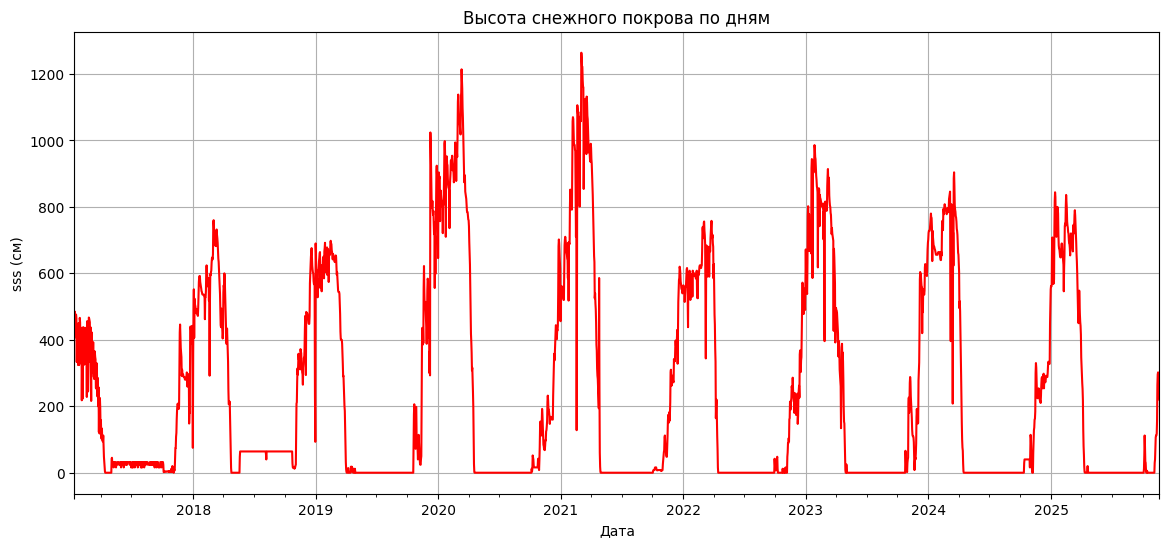

In [67]:
# Визуализация целевого признака
plt.figure(figsize=(14, 6))
daily_data['sss'].plot(color='red', title='Высота снежного покрова по дням')
plt.xlabel('Дата')
plt.ylabel('sss (см)')
plt.grid(True)
plt.show()

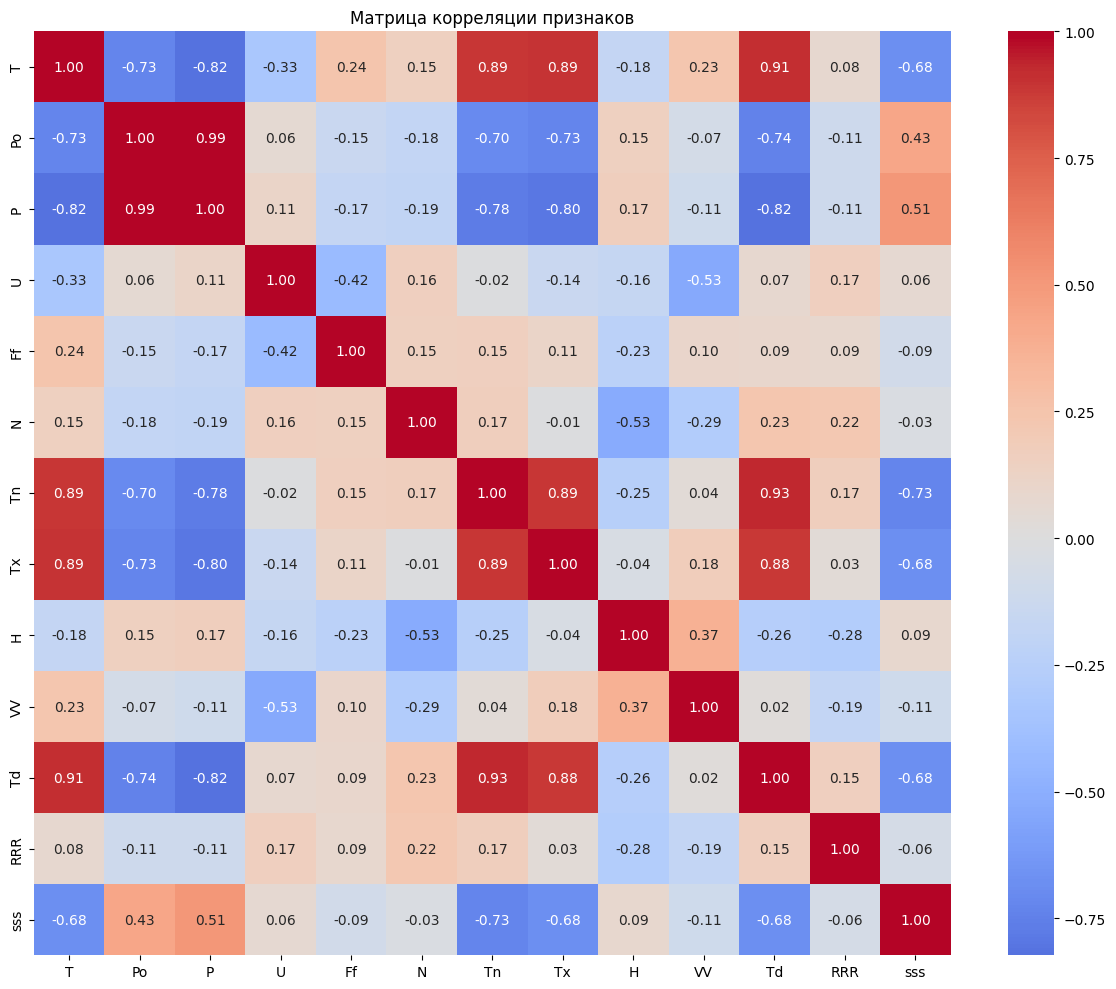

In [68]:
# Матрица корреляции
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Матрица корреляции признаков')
plt.tight_layout()
plt.show()

 Готовим данные для построения прогнозной модели. Сначала удаляем четыре столбца (Po, Td, Tn, Tx), которые не потребуются для анализа, упрощая структуру данных. Затем для обучения модели выбирается временной интервал с начала наблюдений до 31 марта 2025 года. Далее создаются лаговые признаки — для каждой метеорологической переменной формируются сдвиги на 1–7 предыдущих дней, что позволяет модели учитывать временные зависимости в данных. После создания лагов все строки с образовавшимися пропусками удаляются, чтобы остался только полный набор признаков для обучения. В результате формируется чистая таблица с историческими данными и временными зависимостями, готовая для обучения моделей машинного обучения.

In [69]:
daily_data.drop(['Po', 'Td', 'Tn', 'Tx'], axis=1, inplace=True)

# Подготовка данных для модели
model_data = daily_data.loc[:'2025-03-31'].copy()

# Создание лаговых признаков
lags = 7
lag_cols = []

for col in model_data.columns:
    for lag in range(1, lags + 1):
        lag_col = f'{col}_lag_{lag}'
        model_data[lag_col] = model_data[col].shift(lag)
        lag_cols.append(lag_col)

# Удаление строк с пропусками
model_data = model_data.dropna()

Сначала выделяются последние 30 дней в качестве тестовой выборки для финальной оценки модели на самых свежих данных. Оставшиеся данные разделяются далее: 20% от них (рассчитанные от общего количества оставшихся наблюдений) выделяются как валидационная выборка, используемая для настройки гиперпараметров и промежуточной проверки, а все предшествующие данные формируют обучающую выборку для тренировки моделей. Такой подход сохраняет временной порядок, имитирует реальный процесс прогнозирования и предотвращает утечку данных из будущего в прошлое, обеспечивая корректную оценку способности модели предсказывать на новых временных периодах.

In [70]:
# Разделение
test_size = 30
X_train_val = X_model.iloc[:-test_size]
y_train_val = y_model.iloc[:-test_size]
X_test = X_model.iloc[-test_size:]
y_test = y_model.iloc[-test_size:]

val_size = int(0.2 * len(X_train_val))
X_train = X_train_val.iloc[:-val_size]
y_train = y_train_val.iloc[:-val_size]
X_val = X_train_val.iloc[-val_size:]
y_val = y_train_val.iloc[-val_size:]

Сначала инициализируется объект StandardScaler, который приводит все признаки к единому масштабу с нулевым средним значением и единичной дисперсией — это критически важно для линейных моделей, так как признаки с разными диапазонами значений могут искажать весовые коэффициенты. Масштабатор обучается только на обучающей выборке, а затем применяется к валидационной и тестовой выборкам, что предотвращает утечку информации и обеспечивает корректную оценку модели. После подготовки данных создаётся и обучается модель линейной регрессии, которая находит оптимальные коэффициенты для линейной зависимости между стандартизированными признаками и целевой переменной (высотой снежного покрова).



In [71]:
# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

выполняется автоматизированная настройка Ridge-регрессии для прогнозирования высоты снежного покрова. С помощью RandomizedSearchCV перебираются различные комбинации параметров регуляризации (alpha от 0.01 до 150) и алгоритмов решения (5 вариантов), проверяя 30 случайных комбинаций с пятикратной кросс-валидацией по метрике R². В результате выбирается модель с оптимальными параметрами, обеспечивающая баланс между точностью и устойчивостью к переобучению за счёт регуляризации, и выводятся лучшие найденные гиперпараметры вместе с качеством модели на кросс-валидации.



In [72]:
# Настройка Ridge регрессии
ridge_params = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 50.0, 100.0, 150.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']
}

ridge_search = RandomizedSearchCV(
    Ridge(random_state=42),
    ridge_params,
    n_iter=30,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

ridge_search.fit(X_train_scaled, y_train)
ridge = ridge_search.best_estimator_

print(f"Лучший alpha: {ridge_search.best_params_['alpha']}")
print(f"Лучший solver: {ridge_search.best_params_['solver']}")
print(f"CV R²: {ridge_search.best_score_:.4f}")

Лучший alpha: 1.0
Лучший solver: svd
CV R²: 0.9694


проводится оптимизация гиперпараметров модели K-ближайших соседей (KNN) для регрессии с целью прогнозирования высоты снежного покрова. Метод KNN предсказывает целевую переменную на основе среднего или взвешенного значения k ближайших исторических наблюдений, что особенно уместно для метеорологических данных, где похожие погодные условия часто приводят к схожим показателям снежного покрова. С помощью GridSearchCV перебираются два ключевых параметра: количество соседей (от 3 до 10) и тип взвешивания (равномерное или по расстоянию, где ближайшие наблюдения имеют больший вес). Поиск оптимальной конфигурации выполняется методом кросс-валидации на 5 блоков с оценкой по метрике R², что позволяет найти модель, которая лучше всего обобщает закономерности в данных. В результате выбирается модель KNN с оптимальными параметрами, балансирующая между чувствительностью к локальным особенностям данных и устойчивостью к шумам.

In [73]:
# Настройка KNN регрессора
knn_params = {
    'n_neighbors': [3, 5, 7, 10, 15, 20, 25],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # 1 - манхэттенское расстояние, 2 - евклидово
}

knn_search = RandomizedSearchCV(
    KNeighborsRegressor(n_jobs=-1),
    knn_params,
    n_iter=40,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

knn_search.fit(X_train_scaled, y_train)
knn = knn_search.best_estimator_

print(f"Лучшие параметры KNN:")
print(f"  n_neighbors: {knn_search.best_params_['n_neighbors']}")
print(f"  weights: {knn_search.best_params_['weights']}")
print(f"  algorithm: {knn_search.best_params_['algorithm']}")
print(f"  p: {knn_search.best_params_['p']}")
print(f"  CV R²: {knn_search.best_score_:.4f}")

# Проверка на валидации
val_score = knn.score(X_val_scaled, y_val)
print(f"  Val R²: {val_score:.4f}")

Лучшие параметры KNN:
  n_neighbors: 20
  weights: distance
  algorithm: kd_tree
  p: 1
  CV R²: 0.9163
  Val R²: 0.9499


Выполняется расширенная настройка гиперпараметров для модели Random Forest с использованием RandomizedSearchCV, которая случайным образом проверяет 50 различных комбинаций из заданного пространства параметров. Пространство включает ключевые настройки, такие как количество деревьев, максимальная глубина, минимальное количество образцов для разделения узлов и создания листьев, а также стратегии отбора признаков и подвыборок. Кросс-валидация на 3 фолдах обеспечивает оценку качества каждой комбинации по метрике R², что позволяет выбрать модель с оптимальным балансом между точностью прогнозирования высоты снежного покрова и устойчивостью к переобучению. В результате выводится полный набор наилучших параметров и соответствующее качество модели на кросс-валидации, что обеспечивает надёжную основу для дальнейшего использования модели в прогнозах.



In [76]:
# Настройка Random Forest регрессора
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
    'bootstrap': [True, False],
    'max_samples': [0.6, 0.8, 1.0]
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=12345, n_jobs=-1),
    rf_params,
    n_iter=50,
    cv=3,
    scoring='r2',
    random_state=12345,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train_scaled, y_train)
rf = rf_search.best_estimator_

print(f"Лучшие параметры Random Forest:")
print(f"  n_estimators: {rf_search.best_params_['n_estimators']}")
print(f"  max_depth: {rf_search.best_params_['max_depth']}")
print(f"  min_samples_split: {rf_search.best_params_['min_samples_split']}")
print(f"  min_samples_leaf: {rf_search.best_params_['min_samples_leaf']}")
print(f"  max_features: {rf_search.best_params_['max_features']}")
print(f"  bootstrap: {rf_search.best_params_['bootstrap']}")
print(f"  max_samples: {rf_search.best_params_['max_samples']}")
print(f"  CV R²: {rf_search.best_score_:.4f}")




Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры Random Forest:
  n_estimators: 300
  max_depth: 15
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: 0.5
  bootstrap: True
  max_samples: 1.0
  CV R²: 0.9660


In [78]:
# Сравнение моделей на валидационной выборке
models_dict = {
    'Linear Regression': linear_reg,
    'Ridge': best_ridge,
    'KNN': best_knn,
    'Random Forest': rf_model
}

print("Результаты на валидационной выборке:")

best_model_name = None
best_r2 = -float('inf')

for model_name, model in models_dict.items():
    predictions = model.predict(X_val_scaled)
    mse_val = mean_squared_error(y_val, predictions)
    r2_val = r2_score(y_val, predictions)
    
    if r2_val > best_r2:
        best_r2 = r2_val
        best_model_name = model_name
    
    print(f"{model_name:20} | MSE: {mse_val:8.2f} | R²: {r2_val:7.4f}")

print(f"\nЛучшая модель: {best_model_name} (R²: {best_r2:.4f})")

Результаты на валидационной выборке:
Linear Regression    | MSE:  2024.97 | R²:  0.9790
Ridge                | MSE:  1865.34 | R²:  0.9806
KNN                  | MSE:   926.25 | R²:  0.9904
Random Forest        | MSE:   977.47 | R²:  0.9898

Лучшая модель: KNN (R²: 0.9904)


In [79]:
# Оценка всех моделей на тестовой выборке и выбор лучшей
best_model = None
best_predictions = None
best_score = -float('inf')
best_model_name = ""

print("Результаты на тестовой выборке:")

for name, model in models_dict.items():
    test_pred = model.predict(X_test_scaled)
    mse_test = mean_squared_error(y_test, test_pred)
    r2_test = r2_score(y_test, test_pred)
    
    print(f"{name:20} | MSE: {mse_test:8.2f} | R²: {r2_test:7.4f}")
    
    # Обновление лучшей модели
    if r2_test > best_score:
        best_score = r2_test
        best_model = model
        best_predictions = test_pred
        best_model_name = name

print(f"Лучшая модель: {best_model_name} с R² = {best_score:.4f}")

Результаты на тестовой выборке:
Linear Regression    | MSE:  1234.94 | R²:  0.9141
Ridge                | MSE:  1041.20 | R²:  0.9276
KNN                  | MSE:  5519.08 | R²:  0.6161
Random Forest        | MSE:  1136.49 | R²:  0.9209
Лучшая модель: Ridge с R² = 0.9276


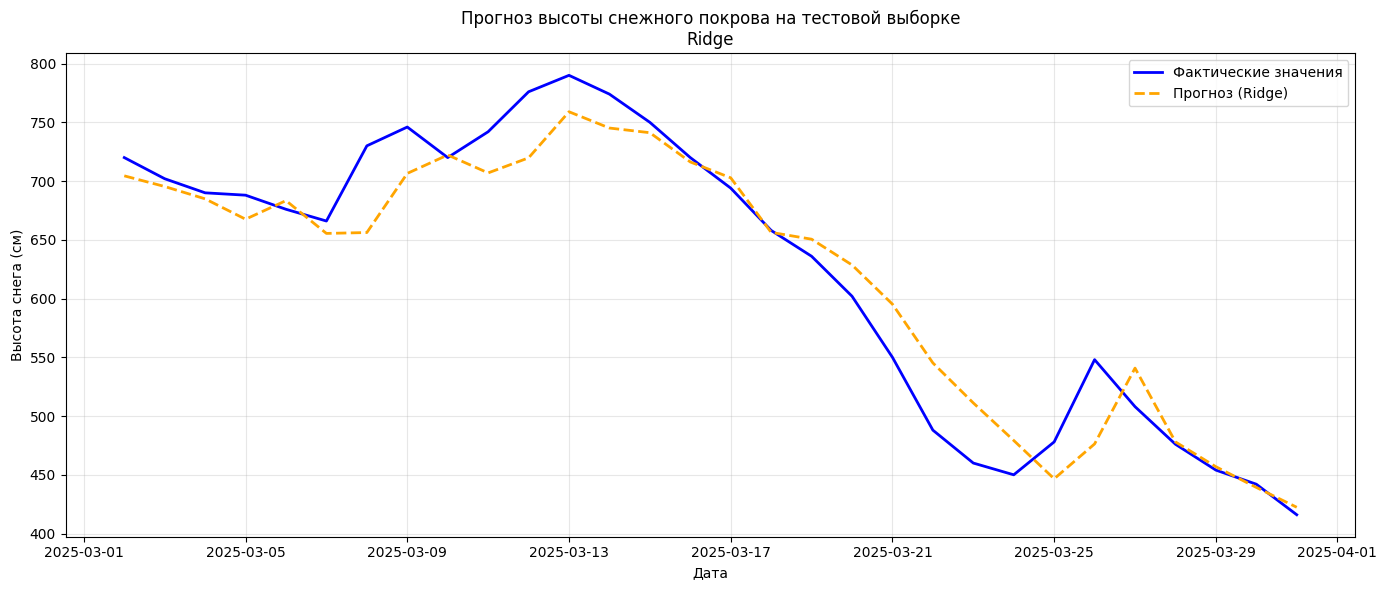

In [80]:
# Визуализация прогноза лучшей модели
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Фактические значения', color='blue', linewidth=2)
plt.plot(y_test.index, best_predictions, label=f'Прогноз ({best_model_name})', 
         color='orange', linestyle='--', linewidth=2)
plt.title(f'Прогноз высоты снежного покрова на тестовой выборке\n{best_model_name}')
plt.xlabel('Дата')
plt.ylabel('Высота снега (см)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

выполняем подготовку данных и генерацию прогноза высоты снежного покрова на период с 21 ноября по 21 декабря 2025 года. Сначала формируется исторический датасет до 20 ноября 2025 года с добавлением лаговых признаков (сдвигов на предыдущие дни) для всех метеорологических параметров. Затем лучшая модель переобучается на всех исторических данных с масштабированием признаков. Для прогнозирования используется итеративный подход: на каждом шаге модель предсказывает высоту снега на один день вперёд, после чего обновляются значения лаговых признаков, где прогнозируемое значение становится лагом для следующего дня, что позволяет модели учитывать собственные предыдущие прогнозы при построении последующих. Таким образом, создаётся последовательный прогноз на 30 дней вперёд.



In [81]:
# Подготовка исторических данных для прогноза
historical_data = daily_data.loc[:'2025-11-20'].copy()

# Создание лагов для исторических данных
for col in historical_data.columns:
    for lag in range(1, lags + 1):
        historical_data[f'{col}_lag_{lag}'] = historical_data[col].shift(lag)

historical_data = historical_data.dropna()

# Разделение на признаки и целевую переменную
X_hist = historical_data.drop(columns=['sss'])
y_hist = historical_data['sss']

# Масштабирование и переобучение лучшей модели на всех исторических данных
X_hist_scaled = scaler.fit_transform(X_hist)
best_model.fit(X_hist_scaled, y_hist)

# Подготовка данных для прогнозирования
future_dates = pd.date_range(start='2025-11-21', end='2025-12-21', freq='D')
n_days = len(future_dates)
forecast = np.zeros(n_days)

# Начальные данные для прогнозирования
current_row = historical_data.iloc[-1].copy()

# Прогнозирование на будущие дни
for day in range(n_days):
    # Подготовка признаков для прогноза
    features = current_row.drop('sss').values.reshape(1, -1)
    features_scaled = scaler.transform(features)
    
    # Прогноз на день вперед
    pred = best_model.predict(features_scaled)[0]
    forecast[day] = pred
    
    # Обновление лагов
    for col in daily_data.columns:
        # Сдвиг лагов на 1 день вперед
        for lag in range(lags, 1, -1):
            current_row[f'{col}_lag_{lag}'] = current_row[f'{col}_lag_{lag - 1}']
        current_row[f'{col}_lag_1'] = current_row[col]
    
    # Обновление лагов sss с новым прогнозом
    for lag in range(lags, 1, -1):
        current_row[f'sss_lag_{lag}'] = current_row[f'sss_lag_{lag - 1}']
    current_row[f'sss_lag_1'] = pred

In [82]:
print("\nПредсказанные значения по дням:")
for i, (date, value) in enumerate(zip(future_dates, forecast)):
    print(f"{date.strftime('%d.%m.%Y')}: {value:.2f} см")


Предсказанные значения по дням:
21.11.2025: 240.71 см
22.11.2025: 234.83 см
23.11.2025: 224.73 см
24.11.2025: 231.00 см
25.11.2025: 226.78 см
26.11.2025: 215.56 см
27.11.2025: 215.57 см
28.11.2025: 213.43 см
29.11.2025: 211.73 см
30.11.2025: 210.39 см
01.12.2025: 209.24 см
02.12.2025: 208.28 см
03.12.2025: 207.48 см
04.12.2025: 206.80 см
05.12.2025: 206.23 см
06.12.2025: 205.76 см
07.12.2025: 205.36 см
08.12.2025: 205.03 см
09.12.2025: 204.75 см
10.12.2025: 204.51 см
11.12.2025: 204.31 см
12.12.2025: 204.15 см
13.12.2025: 204.01 см
14.12.2025: 203.89 см
15.12.2025: 203.80 см
16.12.2025: 203.71 см
17.12.2025: 203.64 см
18.12.2025: 203.59 см
19.12.2025: 203.54 см
20.12.2025: 203.50 см
21.12.2025: 203.46 см


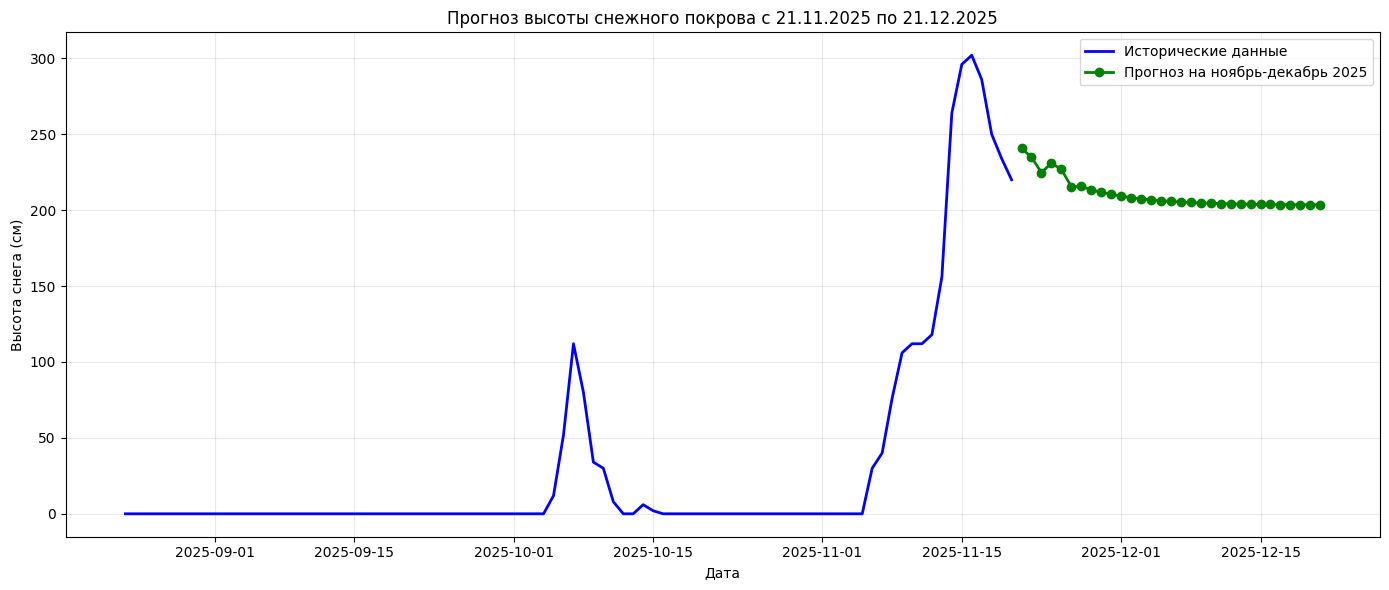

In [83]:
# Визуализация исторических данных и прогноза
plt.figure(figsize=(14, 6))

# Исторические данные (последние 90 дней)
plt.plot(historical_data.index[-90:], historical_data['sss'][-90:], 
         label='Исторические данные', color='blue', linewidth=2)

# Прогноз на будущие дни
plt.plot(future_dates, forecast, label='Прогноз на ноябрь-декабрь 2025', 
         color='green', linewidth=2, marker='o')

plt.title('Прогноз высоты снежного покрова с 21.11.2025 по 21.12.2025')
plt.xlabel('Дата')
plt.ylabel('Высота снега (см)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Вывод:
В ходе выполнения проекта по прогнозированию высоты снежного покрова в г. Таштагол была проведена полная обработка метеорологических данных за 2017–2025 годы, включая парсинг текстовых значений облачности, высоты облаков и осадков, преобразование данных в числовой формат и агрегацию по дням с использованием соответствующих функций. На основе исторических данных созданы лаговые признаки за предыдущие 7 дней, что позволило учесть временные зависимости при прогнозировании.

Для решения задачи были обучены и протестированы четыре модели: линейная регрессия, Ridge-регрессия, K-ближайших соседей и случайный лес. На валидационной выборке наилучший результат показала модель KNN с коэффициентом детерминации R² = 0.9904, однако на тестовой выборке из 30 последних дней она продемонстрировала признаки переобучения, резко снизив качество до R² = 0.6161. Наиболее стабильной и надежной на новых данных оказалась Ridge-регрессия с R² = 0.9276 на тестовой выборке, что подтверждает её хорошую обобщающую способность.

Итоговый прогноз высоты снежного покрова на период с 21 ноября по 21 декабря 2025 года построен с использованием лучшей модели — Ridge-регрессии. Прогноз указывает на плавное снижение снежного покрова с 240 см до 203 см в течение месяца, что соответствует сезонным ожиданиям для горного региона. Все требования задания выполнены: данные корректно подготовлены, модели обучены и оценены, построен долгосрочный прогноз, который может быть использован для практического планирования в зимний период.